# Hyperparameter tuning by randomized-search

In the previous notebook, we showed how to use a grid-search approach to
search for the best hyperparameters maximizing the statistical performance
of a predictive model.

However, a grid-search approach has limitations. It does not scale when
the number of parameters to tune is increasing. Also, the grid will imposed
a regularity during the search which might be problematic.

In this notebook, we will present the another method to tune hyperparameters
called randomized search.

## Our predictive model

Let us reload the dataset as we did previously:

In [1]:
import os

os.makedirs("../../datasets", exist_ok=True)

In [2]:
%%bash

wget -qO "../../datasets/adult-census.csv" "https://github.com/INRIA/scikit-learn-mooc/raw/master/datasets/adult-census.csv"

In [3]:
import pandas as pd

adult_census = pd.read_csv("../../datasets/adult-census.csv")

We extract the column containing the target.

In [4]:
target_name = "class"
target = adult_census[target_name]
target

0         <=50K
1         <=50K
2          >50K
3          >50K
4         <=50K
          ...  
48837     <=50K
48838      >50K
48839     <=50K
48840     <=50K
48841      >50K
Name: class, Length: 48842, dtype: object

We drop from our data the target and the `"education-num"` column which
duplicates the information with `"education"` columns.

In [5]:
data = adult_census.drop(columns=[target_name, "education-num"])
data.head()

age   workclass      education       marital-status          occupation  \
0   25     Private           11th        Never-married   Machine-op-inspct   
1   38     Private        HS-grad   Married-civ-spouse     Farming-fishing   
2   28   Local-gov     Assoc-acdm   Married-civ-spouse     Protective-serv   
3   44     Private   Some-college   Married-civ-spouse   Machine-op-inspct   
4   18           ?   Some-college        Never-married                   ?   

  relationship    race      sex  capital-gain  capital-loss  hours-per-week  \
0    Own-child   Black     Male             0             0              40   
1      Husband   White     Male             0             0              50   
2      Husband   White     Male             0             0              40   
3      Husband   Black     Male          7688             0              40   
4    Own-child   White   Female             0             0              30   

   native-country  
0   United-States  
1   United-States  
2   United-States  
3   United-States  
4   United-States

Once the dataset is loaded, we split it into a training and testing sets.

In [6]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42)

We will create the same predictive pipeline as seen in the grid-search
section.

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

categorical_preprocessor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1)

preprocessor = ColumnTransformer([
    ('cat-preprocessor', categorical_preprocessor, categorical_columns)],
    remainder='passthrough', sparse_threshold=0)

We can display an interactive diagram with the following command:

In [8]:
from sklearn import set_config

set_config(display="diagram")

In [9]:
# for the moment this line is required to import HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", HistGradientBoostingClassifier(
        random_state=42, max_leaf_nodes=4))
])
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat-preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                random_state=42))])

## Tuning using a randomized-search

With the `GridSearchCV` estimator, the parameters need to be specified
explicitly. We already mentioned that exploring a large number of values for
different parameters will be quickly untractable.

Instead, we can randomly generate the parameter candidates. Indeed,
such approach avoids the regularity of the grid. Hence, adding more
evaluations can increase the resolution in each direction. This is the
case in the frequent situation where the choice of some hyperparameters
is not very important, as for hyperparameter 2 in the figure below.

![Randomized vs grid search](https://github.com/INRIA/scikit-learn-mooc/raw/master/figures/grid_vs_random_search.svg)

Indeed, the number of evaluation points need to be divided across the
two different hyperparameters. With a grid, the danger is that the
region of good hyperparameters fall between the line of the grid: this
region is aligned with the grid given that hyperparameter 2 has a weak
influence. Rather, stochastic search will sample hyperparameter 1
independently from hyperparameter 2 and find the optimal region.

The `RandomizedSearchCV` class allows for such stochastic search. It is
used similarly to the `GridSearchCV` but the sampling distributions
need to be specified instead of the parameter values. For instance, we
will draw candidates using a log-uniform distribution because the parameters
we are interested in take positive values with a natural log scaling (.1 is
as close to 1 as 10 is).

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">Random search (with <tt class="docutils literal">RandomizedSearchCV</tt>) is typically beneficial compared
to grid search (with <tt class="docutils literal">GridSearchCV</tt>) to optimize 3 or more
hyperparameters.</p>
</div>

We will optimize 3 other parameters in addition to the ones we
optimized above:

* `max_iter`: it corresponds to the number of trees in the ensemble;
* `min_samples_leaf`: it corresponds to the minimum number of samples
  required in a leaf;
* `max_bins`: it corresponds to the maximum number of bins to construct the
  histograms.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">The <tt class="docutils literal">loguniform</tt> function from SciPy returns a floating number. Since we
want to use this distribution to create integer, we will create a class that
will cast the floating number into an integer.</p>
</div>

In [10]:
from scipy.stats import loguniform

class loguniform_int:
    """Integer valued version of the log-uniform distribution"""
    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

Now, we can define the randomized search using the different distributions.

In [11]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'classifier__l2_regularization': loguniform(1e-6, 1e3),
    'classifier__learning_rate': loguniform(0.001, 10),
    'classifier__max_leaf_nodes': loguniform_int(2, 256),
    'classifier__min_samples_leaf': loguniform_int(1, 100),
    'classifier__max_bins': loguniform_int(2, 255)}

model_random_search = RandomizedSearchCV(
    model, param_distributions=param_distributions, n_iter=10,
    n_jobs=4, cv=5)
model_random_search.fit(data_train, target_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                sparse_threshold=0,
                                                                transformers=[('cat-preprocessor',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['workclass',
                                                                                'education',
                                                                                'marital-status',
                                                                                'occupation',
                                                                                'relationship',
                                                                                'race',
                                                                                'sex',
                                                                                'native-country'])])),
                                             ('classifier',
                                              Hi...
                   param_distributions={'classifier__l2_regularization': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f298b5e0c40>,
                                        'classifier__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f298b5e0f10>,
                                        'classifier__max_bins': <__main__.loguniform_int object at 0x7f298b5f7790>,
                                        'classifier__max_leaf_nodes': <__main__.loguniform_int object at 0x7f298b5e0f70>,
                                        'classifier__min_samples_leaf': <__main__.loguniform_int object at 0x7f298b5f7460>})

Then, we can compute the accuracy score on the test set.

In [12]:
accuracy = model_random_search.score(data_test, target_test)

print(f"The test accuracy score of the best model is "
      f"{accuracy:.2f}")

The test accuracy score of the best model is 0.87


In [13]:
from pprint import pprint

print("The best parameters are:")
pprint(model_random_search.best_params_)

The best parameters are:
{'classifier__l2_regularization': 0.31027139924943287,
 'classifier__learning_rate': 0.04194578658795616,
 'classifier__max_bins': 56,
 'classifier__max_leaf_nodes': 67,
 'classifier__min_samples_leaf': 27}


We can inspect the results using the attributes `cv_results` as we previously
did.

In [14]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

In [15]:
# get the parameter names
column_results = [
    f"param_{name}" for name in param_distributions.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]

cv_results = pd.DataFrame(model_random_search.cv_results_)
cv_results = cv_results[column_results].sort_values(
    "mean_test_score", ascending=False)
cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

l2_regularization learning_rate max_leaf_nodes min_samples_leaf max_bins  \
9          0.310271      0.041946             67               27       56   
4        112.159653      0.742989             13               39       67   
0          0.000226       0.10168            183               10       35   
6          0.267661      0.048552              7                9        9   
5          0.150653      0.046813              3               74       13   
2        191.432702      0.432389            171                3        3   
1         28.177309      0.349574             54                8        2   
8          5.407623      1.236283              3                3      108   
7          0.009141      0.006377             45                2        4   
3          0.059568      2.775665            118                5        2   

   mean_test_score  std_test_score  rank_test_score  
9         0.857771        0.002531                1  
4         0.857416        0.001034                2  
0         0.853485        0.002839                3  
6         0.833747        0.002837                4  
5         0.817095        0.001377                5  
2         0.804837        0.001880                6  
1         0.802708        0.002373                7  
8         0.799760        0.011148                8  
7         0.781769        0.001648                9  
3         0.593948        0.125067               10

In practice, a randomized hyperparameter search is usually run with a large
number of iterations. In order to avoid the computation cost and still make a
decent analysis, we load the results obtained from a similar search with 200
iterations.

In [16]:
%%time
model_random_search = RandomizedSearchCV(
    model, param_distributions=param_distributions, n_iter=500,
    n_jobs=4, cv=5)
model_random_search.fit(data_train, target_train)
cv_results =  pd.DataFrame(model_random_search.cv_results_)
cv_results.to_csv("../../datasets/randomized_search_results.csv")

CPU times: user 44.6 s, sys: 3.01 s, total: 47.6 s
Wall time: 6min 30s


In [16]:
cv_results = pd.read_csv("../../datasets/randomized_search_results.csv",
    index_col=0)

As we have more than 2 paramters in our grid-search, we cannot visualize the
results using a heatmap. However, we can us a parallel coordinates plot.

In [17]:
cv_results[column_results].rename(
    shorten_param, axis=1).sort_values("mean_test_score")

l2_regularization  learning_rate  max_leaf_nodes  min_samples_leaf  \
54            0.105698       4.370859               2                10   
209           0.000077       4.242856               3                52   
35            0.039924       4.111409               2                10   
183           0.000162       4.057099               2                19   
109           0.000002       8.944180               3                11   
..                 ...            ...             ...               ...   
48            0.000647       0.118048              13                 2   
430           0.000083       0.227569              14                14   
239           0.000052       0.149393              26                 4   
416           0.335625       0.351861              13                77   
107           4.207781       0.171613              18                 8   

     max_bins  mean_test_score  std_test_score  rank_test_score  
54         49         0.283476        0.005123              493  
209        58         0.283476        0.005123              493  
35          4         0.283476        0.005123              493  
183        21         0.283476        0.005123              493  
109       155         0.283476        0.005123              493  
..        ...              ...             ...              ...  
48        222         0.869701        0.001832                5  
430       187         0.869810        0.002408                4  
239       251         0.870028        0.002114                3  
416       154         0.870274        0.002408                2  
107       140         0.870902        0.001579                1  

[500 rows x 8 columns]

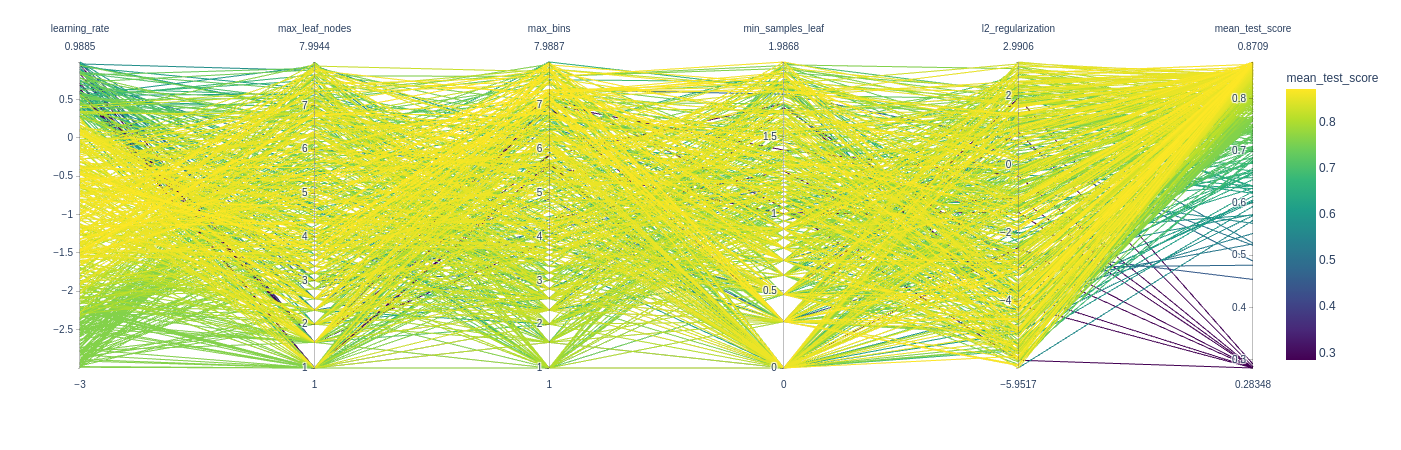

In [18]:
import numpy as np
import plotly.express as px

fig = px.parallel_coordinates(
    cv_results.rename(shorten_param, axis=1).apply({
        "learning_rate": np.log10,
        "max_leaf_nodes": np.log2,
        "max_bins": np.log2,
        "min_samples_leaf": np.log10,
        "l2_regularization": np.log10,
        "mean_test_score": lambda x: x}),
    color="mean_test_score",
    color_continuous_scale=px.colors.sequential.Viridis,
)
fig.show()

![parallel coordinate plot](./figures/parallel_coordinate_plot_randomized_search.png)

The parallel coordinates plot will display the values of the hyperparameters
on different columns while the performance metric is color coded. Thus, we
are able to quickly inspect if there is a range of hyperparameters which is
working or not.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">We <strong>transformed most axis values by taking a log10 or log2</strong> to
spread the active ranges and improve the readability of the plot.</p>
</div>

It is possible to **select a range of results by clicking and holding on
any axis** of the parallel coordinate plot. You can then slide (move)
the range selection and cross two selections to see the intersections.

In this notebook, we have seen how randomized search offer a valuable
alternative to grid-search when the number of hyperparameters to tune is more
than two. It also alleviates the regularity imposed by the grid that might be
problematic sometimes.